In [128]:
import os
import random
import tarfile
import sys
import cv2
import time
import tensorflow as tf
from IPython.display import clear_output
from scipy import ndimage
import numpy as np
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt
%matplotlib inline

class VideoCamera(object):
    
    def __init__(self, index=0):
        self.video = cv2.VideoCapture(index)
        self.index = index
        self.is_opened = self.video.isOpened()
        print self.video.isOpened()

    def __del__(self):
        self.video.release()
    
    def get_frame(self, in_grayscale=False):
        _, frame = self.video.read()
        if in_grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return frame
    
class FaceDetector(object):
    def __init__(self, xml_path):
        self.classifier = cv2.CascadeClassifier(xml_path)
    
    def detect(self, image, biggest_only=True):
        scale_factor = 1.2
        min_neighbors = 5
        min_size = (30, 30)
        biggest_only = True
        flags = cv2.CASCADE_FIND_BIGGEST_OBJECT | \
                    cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
                    cv2.CASCADE_SCALE_IMAGE
        faces_coord = self.classifier.detectMultiScale(image,
                                                       scaleFactor=scale_factor,
                                                       minNeighbors=min_neighbors,
                                                       minSize=min_size,
                                                       flags=flags)
        return faces_coord

def draw_rectangle(image, coords):
    for (x, y, w, h) in coords:
        w_rm = int(0.2 * w / 2) 
        cv2.rectangle(image, (x + w_rm, y), (x + w - w_rm, y + h), 
                              (150, 150, 0), 8)
        
def cut_faces(image, faces_coord):
    faces = []
    for (x, y, w, h) in faces_coord:
        w_rm = int(0.2 * w / 2)
        faces.append(image[y: y + h, x + w_rm: x + w - w_rm])
    return faces

def resize(images, size=(80, 80)):
    images_norm = []
    for image in images:
        if image.shape < size:
            image_norm = cv2.resize(image, size, 
                                    interpolation = cv2.INTER_AREA)
        else:
            image_norm = cv2.resize(image, size, 
                                    interpolation = cv2.INTER_CUBIC)
        images_norm.append(image_norm)
    return images_norm 
        
def plt_show(image, title=""):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title(title)
    plt.imshow(image)
    plt.show()
    
def normalize_faces(frame, faces_coord):
    faces = cut_faces(frame, faces_coord)
    faces = resize(faces)
    return faces
        
# Open a new thread to manage the external cv2 interaction
cv2.startWindowThread()

1

### Taking Pictures

In [175]:
webcam = VideoCamera()
if webcam.is_opened:
    detector = FaceDetector("xml/frontal_face.xml")

    pictures_folder = os.path.join('data', 'pictures_tf')
    folder = os.path.join(pictures_folder, raw_input('Person: ').lower()) # input name
    cv2.namedWindow("PyData Tutorial", cv2.WINDOW_AUTOSIZE)

    if not os.path.exists(folder):
        os.mkdir(folder)
        counter = 1
        timer = 0
        while counter < 21 : # take 20 pictures
            frame = webcam.get_frame()
            faces_coord = detector.detect(frame) # detect
            if len(faces_coord) and timer % 700 == 50: # every Second or so
                faces = normalize_faces(frame, faces_coord) # norm pipeline
                cv2.imwrite(folder + '/' + str(counter) + '.jpg', faces[0])
                plt_show(faces[0], "Images Saved:" + str(counter))
                clear_output(wait = True) # saved face in notebook
                counter += 1
            draw_rectangle(frame, faces_coord) # rectangle around face
            cv2.imshow("PyData Tutorial", frame) # live feed in external
            cv2.waitKey(50)
            timer += 50
        cv2.destroyAllWindows()
    else:
        print "This name already exists."
del webcam

True
Person: 
This name already exists.


### Reviewing Data

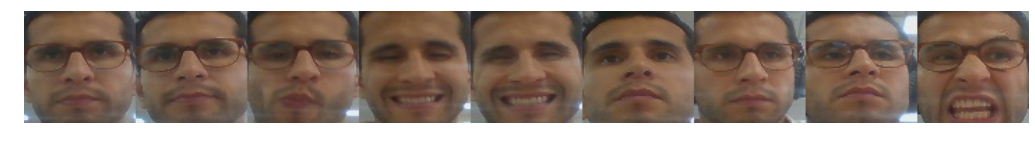

Maximum pixel intensity value: 255.00
Shape of images (80, 80, 3)


In [176]:
# display a two random image from each letter in the train folder
def print_images(folders):
    images = []
    for folder in folders:
        images_path = os.listdir(folder)
        random.choice(images_path)
        for i in range(3):
            image_path = os.path.join(folder,
                                      random.choice(images_path))
            images.append(ndimage.imread(image_path))
    plt.figure(figsize=(20, 2))
    plt.imshow(np.hstack(images))
    plt.axis('off')
    plt.show()
    print 'Maximum pixel intensity value: %.2f' %np.amax(images[0])
    print 'Shape of images ' + str(images[0].shape) 

data_folders = os.listdir(os.path.join('data', 'pictures_tf'))
data_folders = [os.path.join('data', 'pictures_tf', folder) for folder in data_folders]
print_images(data_folders)

### Building the dataset

In [177]:
image_size = 80
num_channels = 3
num_images_per_class = 20
num_classes = 3

def number_of_images(folders):
    
    dataset = np.ndarray((num_images_per_class * num_classes, image_size, image_size, num_channels), dtype=np.int32)
    labels = np.ndarray(num_images_per_class * num_classes, dtype=np.int32)
    num_per_class = {}
    counter = 0
    for image_class, folder in enumerate(folders):
        per_class_counter = 0
        for image_name in os.listdir(folder):
            if per_class_counter < num_images_per_class:
                image_path = os.path.join(folder, image_name)
                try:
                    image = ndimage.imread(image_path)
#                     image = (image - np.max(image) / 2) / np.max(image)
                    if image.shape == (image_size, image_size, num_channels):
                        dataset[counter] = image
                        labels[counter] = image_class
                        counter += 1
                        per_class_counter += 1
                    else:
                        raise Exception("Unexpected image shape")
                except Exception as e:
                    print 'Unable to use image: ' + str(e)
        num_per_class[image_class] = per_class_counter
    return num_per_class, dataset, labels

num_per_class, dataset, labels = number_of_images(data_folders)
print 'Total number of images: %d' %dataset.shape[0]
print 'Number of images per class:'
print num_per_class
images_per_class = np.amin(num_per_class.values())
print 'We take %d images per class' %images_per_class
print 'Images Shape:' + str(dataset[0].shape)
print 'Dataset shape: ' + str(dataset.shape)

Total number of images: 60
Number of images per class:
{0: 20, 1: 20, 2: 20}
We take 20 images per class
Images Shape:(80, 80, 3)
Dataset shape: (60, 80, 80, 3)


In [178]:
train_size = 15
valid_size = 3
test_size = 2

train_dataset = np.ndarray((train_size * num_classes, image_size, image_size, num_channels), dtype=np.float32)
train_labels = np.ndarray(train_size * num_classes, dtype=np.int32)

valid_dataset = np.ndarray((valid_size * num_classes, image_size, image_size, num_channels), dtype=np.float32)
valid_labels = np.ndarray(valid_size * num_classes, dtype=np.int32)

test_dataset = np.ndarray((test_size * num_classes, image_size, image_size, num_channels), dtype=np.float32)
test_labels = np.ndarray(test_size * num_classes, dtype=np.int32)

for i in range(num_classes):

    start_set, end_set = i * num_images_per_class, (i + 1) * num_images_per_class
    start_train, end_train = i * train_size, (i + 1) * train_size
    start_valid, end_valid = i * valid_size, (i + 1) * valid_size
    start_test, end_test = i * test_size, (i + 1) * test_size
    
    letter_set = dataset[start_set : end_set]
    np.random.shuffle(letter_set)
    
    train_dataset[start_train : end_train] = letter_set[0: train_size]
    train_labels[start_train : end_train] = i
    
    valid_dataset[start_valid : end_valid] = letter_set[train_size: train_size + valid_size]
    valid_labels[start_valid : end_valid] = i
    
    test_dataset[start_test : end_test] = letter_set[train_size + valid_size: train_size + valid_size + test_size]
    test_labels[start_test : end_test] = i

In [179]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [180]:
def reformat(dataset, labels):
    # as.type is not needed as the array is already float32 but just in case
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print("Train Shapes --> Dataset: %s   Labels: %s" %(train_dataset.shape, train_labels.shape))
print("Valid Shapes --> Dataset: %s   Labels: %s" %(valid_dataset.shape, valid_labels.shape))
print("Test Shapes  --> Dataset: %s   Labels: %s" %(test_dataset.shape, test_labels.shape))

Train Shapes --> Dataset: (45, 80, 80, 3)   Labels: (45, 2)
Valid Shapes --> Dataset: (9, 80, 80, 3)   Labels: (9, 2)
Test Shapes  --> Dataset: (6, 80, 80, 3)   Labels: (6, 2)


In [181]:
def accuracy(predictions, labels):
    return 100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0]

In [182]:
batch_size = 2
patch_size = 5
depth1 = 16
depth2 = 32
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    
    #Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    patch1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    patch1_biases = tf.Variable(tf.zeros([depth1]))
    
    patch2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    patch2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    
    # divided by four because that is the size once the patches have scanned the image
    layer1_weights = tf.Variable(tf.truncated_normal(
                                 [image_size // 4 * image_size // 4 * depth2, num_hidden], stddev=0.1))
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Model
    def model(data, training):
        # first convolution layer. Stride only matter in two elements in the middle
        conv1 = tf.nn.conv2d(data, patch1_weights, [1, 1, 1, 1], padding="SAME")
        conv1 = tf.nn.relu(conv1 + patch1_biases)
        conv1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], padding="SAME" )
        
        # second convolution layer
        conv2 = tf.nn.conv2d(conv1, patch2_weights, [1, 1, 1, 1], padding="SAME")
        conv2 = tf.nn.relu(conv2 + patch2_biases)
        conv2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], padding="SAME" )

        # reshape to apply fully connected layer
        shape_conv = conv2.get_shape().as_list()
        input_hidden = tf.reshape(conv2, [shape_conv[0], shape_conv[1] * shape_conv[2] * shape_conv[3]])
        hidden_layer = tf.nn.relu(tf.matmul(input_hidden, layer1_weights) + layer1_biases)
        
        # adding dropout layer
        if training:
            hidden_layer = tf.nn.dropout(hidden_layer, 0.6)
        
        return tf.matmul(hidden_layer, layer2_weights) + layer2_biases
    
    # training computation
    logits = model(tf_train_dataset, True)
    regularization = tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
           .0005 * regularization
    
    # Optimizer
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 200, 0.95, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, False))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, False))

In [183]:
num_steps = 21

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # randomize offset
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 10 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 502.048828
Minibatch accuracy: 0.0%
Validation accuracy: 33.3%
Minibatch loss at step 10: 1666565017457569983970334444879872.000000
Minibatch accuracy: 50.0%
Validation accuracy: 33.3%
Minibatch loss at step 20: 1665728788961032709594640086466560.000000
Minibatch accuracy: 50.0%
Validation accuracy: 33.3%
Test accuracy: 33.3%
